In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from dataset import LEVIRCDDataset
from utils import *
from model import *
from train import *
from loss_func import *

In [2]:
image_dir_A_train = '../data/lesson_1/train/A/'
image_dir_B_train = '../data/lesson_1/train/B/'
label_dir_train = '../data/lesson_1/train/label/'

#validation data
image_dir_A_val = '../data/lesson_1/val/A/'
image_dir_B_val = '../data/lesson_1/val/B/'
label_dir_val = '../data/lesson_1/val/label/'

#test data
image_dir_A_test = '../data/lesson_1/test/A/'
image_dir_B_test = '../data/lesson_1/test/B/'
label_dir_test = '../data/lesson_1/test/label/'


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

### Loss function

In [4]:
lossfunction_dict = {"DiceLoss": DiceLoss(), "FocalLoss": FocalLoss(), 
                     "IoULoss": IoULoss(), "TverskyLoss": TverskyLoss(),
                     "BCEDiceLoss": BCEDiceLoss()}


In [5]:
levir_cd_dataset_train = LEVIRCDDataset(image_dir_A_train, image_dir_B_train, label_dir_train, transform=transform)
levir_cd_dataset_val = LEVIRCDDataset(image_dir_A_val, image_dir_B_val, label_dir_val, transform=transform)
levir_cd_dataset_test = LEVIRCDDataset(image_dir_A_test, image_dir_B_test, label_dir_test, transform=transform)

# DataLoader
train_loader = DataLoader(levir_cd_dataset_train, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)
validate_loader = DataLoader(levir_cd_dataset_val, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(levir_cd_dataset_test, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)


In [17]:
for loss_name, loss_func in lossfunction_dict.items():
    model = UNet(in_channels=6, out_channels=1)
    model.to(device); 
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    print(f"Training with {loss_name}")
    train_losses, train_ious, train_dices, val_losses, val_ious, val_dices = train_model(model, loss_func, optimizer,
                                                                                     scheduler,train_loader, 
                                                                                     validate_loader, num_epochs=100, save_name=f'unet_levir_cd_{loss_name}_w')    
    print(f"Training with {loss_name} finished")
    print("=====================================")

Training with DiceLoss
Epoch 1/100, Training Loss: 0.8803, IoU: 0.0819, DICE: 0.1423
Epoch 1/100, Validation Loss: 0.9234, IoU: 0.0000, DICE: 0.0000
----------------------------------------
Epoch 2/100, Training Loss: 0.8184, IoU: 0.1371, DICE: 0.2272
Epoch 2/100, Validation Loss: 0.9207, IoU: 0.0049, DICE: 0.0083
----------------------------------------
Saving the best model with IoU: 0.004932853393256664
Epoch 3/100, Training Loss: 0.7990, IoU: 0.1752, DICE: 0.2803
Epoch 3/100, Validation Loss: 0.9011, IoU: 0.0857, DICE: 0.1194
----------------------------------------
Saving the best model with IoU: 0.08569319918751717
Epoch 4/100, Training Loss: 0.7835, IoU: 0.2171, DICE: 0.3350
Epoch 4/100, Validation Loss: 0.7889, IoU: 0.2424, DICE: 0.3581
----------------------------------------
Saving the best model with IoU: 0.24242588132619858
Epoch 5/100, Training Loss: 0.7699, IoU: 0.2563, DICE: 0.3832
Epoch 5/100, Validation Loss: 0.7724, IoU: 0.2723, DICE: 0.3904
--------------------------

### Results

###### DICE loss

In [9]:
def plot_metrics(test_loader, model, criterion, path_2_model, path_2_metric):
    model.load_state_dict(torch.load(path_2_model))
    model.eval()
    test_loss, test_iou, test_dice = validate_model(model, test_loader, criterion)
    print(f"Test Loss: {test_loss}, Test IoU: {test_iou}, Test Dice: {test_dice}")
    metrics = torch.load(path_2_metric)
    train_losses = remove_outliers(metrics['train_losses'])
    train_ious = remove_outliers(metrics['train_ious'])
    train_dices = remove_outliers(metrics['train_dices'])
    val_losses = remove_outliers(metrics['val_losses'])
    val_ious = remove_outliers(metrics['val_ious'])
    val_dices = remove_outliers(metrics['val_dices'])

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.figure(figsize=(10, 5))
    plt.plot(train_ious, label='train iou')
    plt.plot(val_ious, label='validation iou')
    plt.plot(train_dices, label='train dice', linestyle='dashed')
    plt.plot(val_dices, label='validation dice', linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('IoU/Dice')
    plt.legend()

    

Test Loss: 0.17639358341693878, Test IoU: 0.564628541469574, Test Dice: 0.6688951849937439


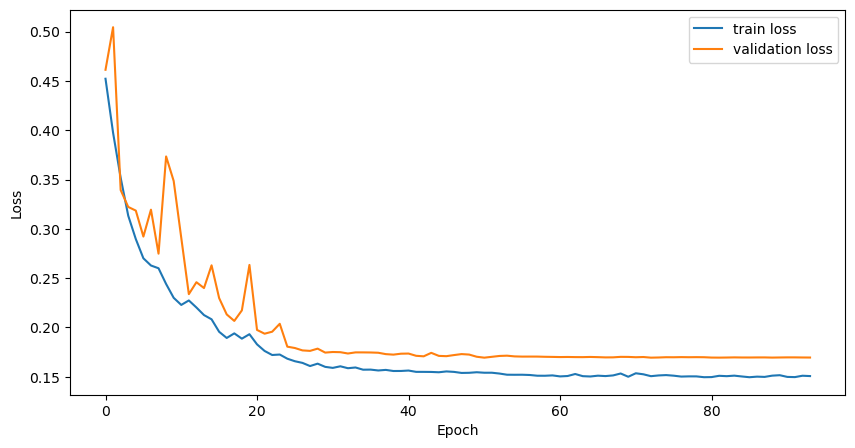

<Figure size 1000x500 with 0 Axes>

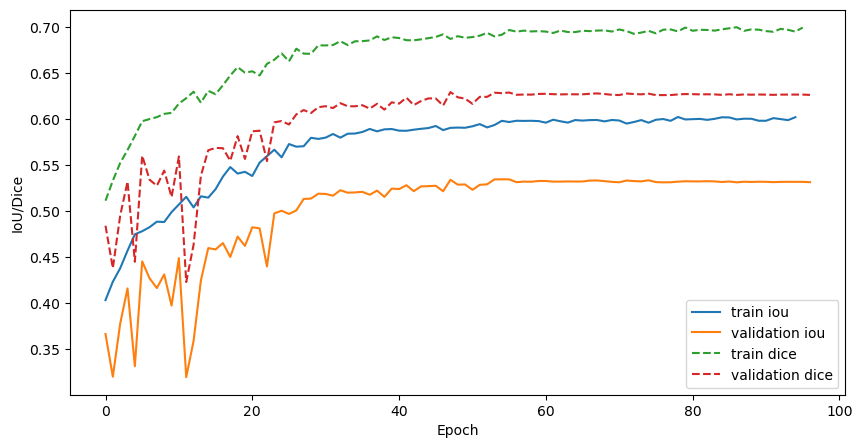

In [12]:
plot_metrics(test_loader, model, lossfunction_dict['DiceLoss'], '../model_weights/1726489094/unet_levir_cd_DiceLoss_1726489094_best.pth', '../model_weights/1726489094/unet_levir_cd_DiceLoss_1726489094_metrics.pth')

#### Focal Loss

Test Loss: 0.6649348139762878, Test IoU: 0.5421047359704971, Test Dice: 0.6514909565448761


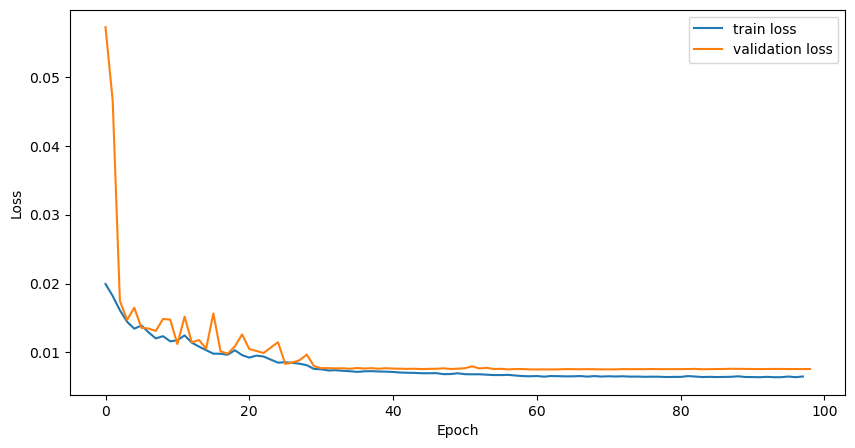

<Figure size 1000x500 with 0 Axes>

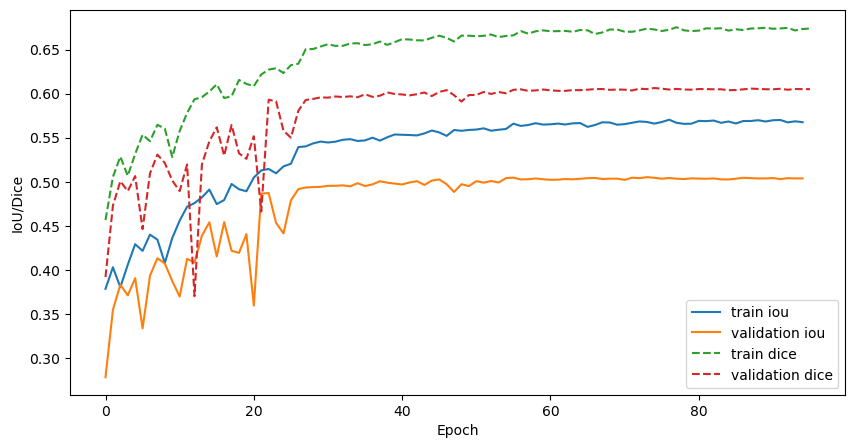

In [14]:
path2_model = '/home/akansh-i2sc/Desktop/fast-ai-course/model_weights/1726490188/unet_levir_cd_FocalLoss_1726490188_best.pth'
plot_metrics(test_loader, model, lossfunction_dict['BCEDiceLoss'], path2_model, path2_model.replace('best.pth', 'metrics.pth'))

### IOU loss

Test Loss: 0.48218777775764465, Test IoU: 0.5731530785560608, Test Dice: 0.6763293892145157


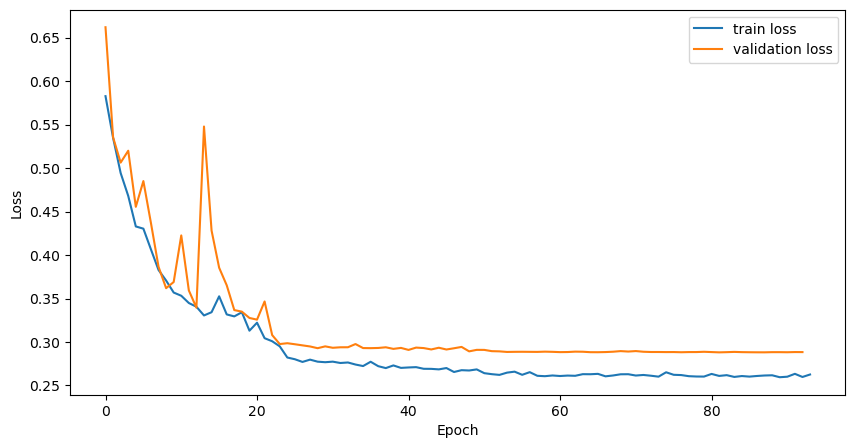

<Figure size 1000x500 with 0 Axes>

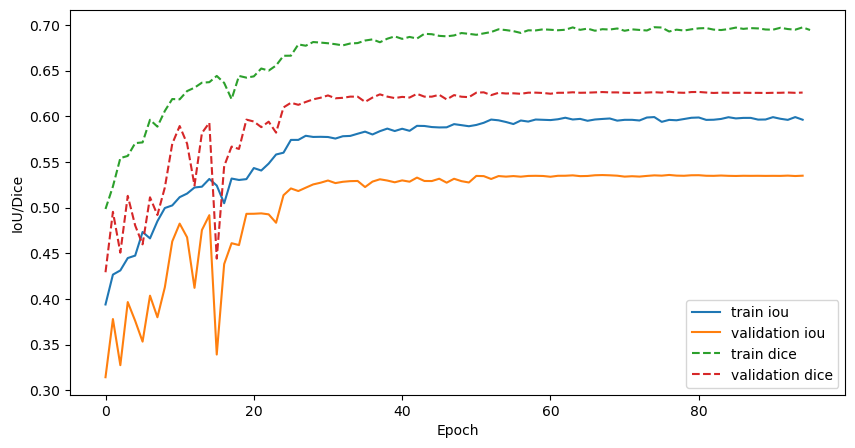

In [15]:
path2_model = '/home/akansh-i2sc/Desktop/fast-ai-course/model_weights/1726491293/unet_levir_cd_IoULoss_1726491293_best.pth'
plot_metrics(test_loader, model, lossfunction_dict['BCEDiceLoss'], path2_model, path2_model.replace('best.pth', 'metrics.pth'))

#### Tverskyloss

Test Loss: 0.5205135270953178, Test IoU: 0.5718982964754105, Test Dice: 0.6765004396438599


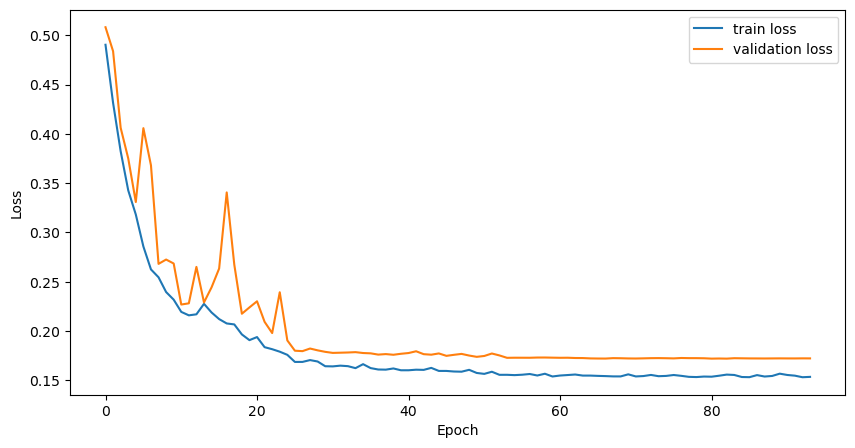

<Figure size 1000x500 with 0 Axes>

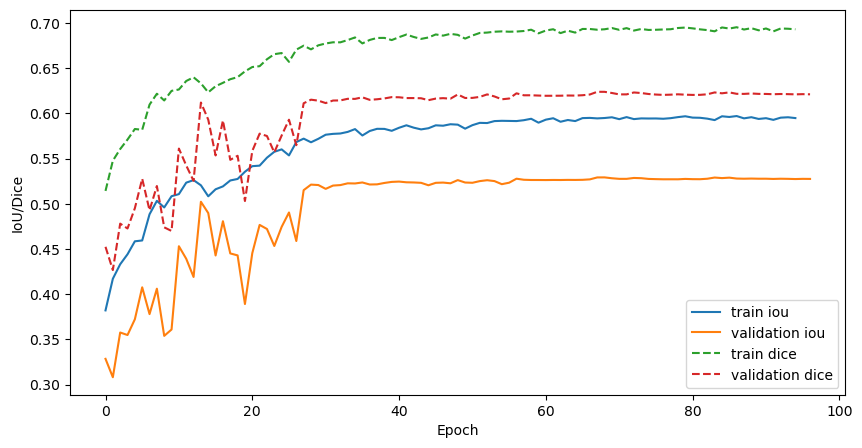

In [16]:
path2_model = "/home/akansh-i2sc/Desktop/fast-ai-course/model_weights/1726492399/unet_levir_cd_TverskyLoss_1726492399_best.pth"
plot_metrics(test_loader, model, lossfunction_dict['BCEDiceLoss'], path2_model, path2_model.replace('best.pth', 'metrics.pth'))

### DiceBCEloss

Test Loss: 0.24562356621026993, Test IoU: 0.5667423158884048, Test Dice: 0.6705189943313599


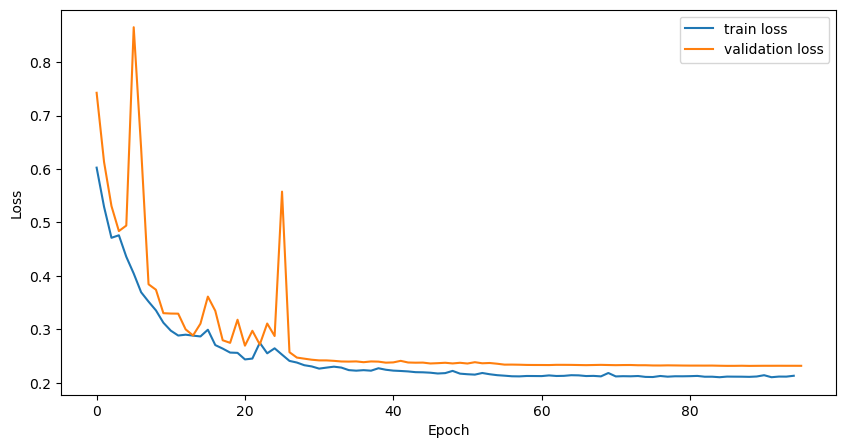

<Figure size 1000x500 with 0 Axes>

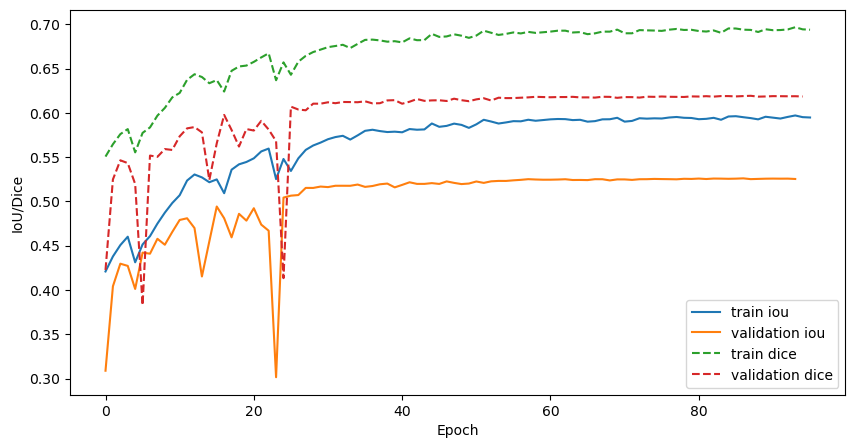

In [13]:
path2_model = '/home/akansh-i2sc/Desktop/fast-ai-course/model_weights/1726493492/unet_levir_cd_BCEDiceLoss_1726493492_best.pth'
plot_metrics(test_loader, model, lossfunction_dict['BCEDiceLoss'], path2_model, path2_model.replace('best.pth', 'metrics.pth'))

In [12]:
model = UNet(in_channels=6, out_channels=1).to(device)
test_loader = DataLoader(levir_cd_dataset_test, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)
model.load_state_dict(torch.load('../model_weights/1726411249/unet_levir_cd_dice_loss_1726411249_best.pth'))
criterion = nn.BCELoss()
epoch_loss, mean_iou, mean_dice = validate_model(model, test_loader, criterion)
print(f'Loss: {epoch_loss:.4f}, IoU: {mean_iou:.4f}, DICE: {mean_dice:.4f}')

Loss: 0.4309, IoU: 0.5725, DICE: 0.6754


In [35]:
metrics = torch.load("../model_weights/1726411249/unet_levir_cd_dice_loss_1726411249_metrics.pth")

In [38]:
#put it in utils
def remove_outliers(data, m=2):
    return np.array(data)[abs(data - np.mean(data)) < m * np.std(data)]

In [39]:
train_losses = remove_outliers(metrics['train_losses'])
train_ious = remove_outliers(metrics['train_ious'])
train_dices = remove_outliers(metrics['train_dices'])
val_losses = remove_outliers(metrics['val_losses'])
val_ious = remove_outliers(metrics['val_ious'])
val_dices = remove_outliers(metrics['val_dices'])


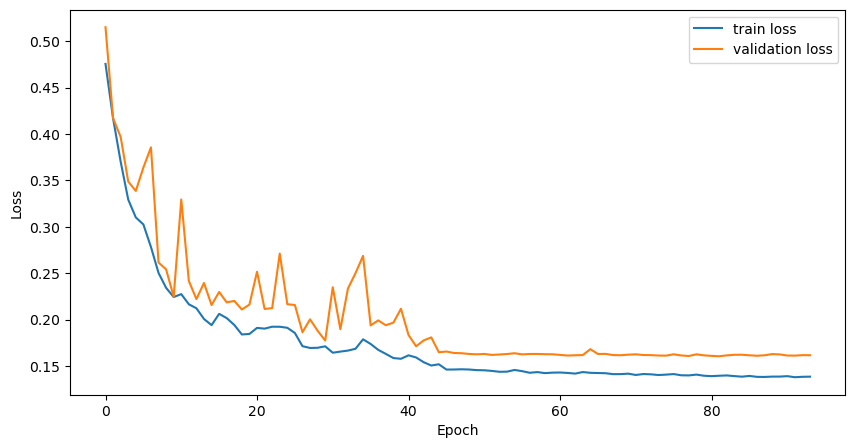

In [40]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()